In [1]:
from tinyai import *

In [2]:
import pickle,gzip,math,os,time,shutil,random,logging,torch
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval import metrics

In [13]:
from datasets import load_dataset

dsd = load_dataset("daloopa/fashion-mnist-interview")

xl,yl = 'image','label'

# xmean,xstd = 0.28, 0.35
# @inplace
# def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]
@inplace
def transformi(b): b[xl] = [TF.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b[xl]]


bs = 256
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, batch_size=bs, num_workers=16, pin_memory=True)

In [4]:
x,y = next(iter(dls.train))
x.shape

torch.Size([64, 1, 32, 32])

In [5]:
from torch import nn
import torch
# pool of square window of size=3, stride=2
m = nn.AvgPool2d(3, stride=2)
# pool of non-square window
m = nn.AvgPool2d((3, 2), stride=(2, 1))
input = torch.randn(20, 16, 50, 32)
output = m(input)
output.shape

torch.Size([20, 16, 24, 31])

In [6]:
ResBlock(1, 16, ks=5, norm=nn.BatchNorm2d)(x).shape

torch.Size([64, 16, 32, 32])

In [7]:
from functools import partial
from torch import nn
from torch import optim


def get_model():
    act = partial(GeneralReLU, leak=0.1, sub=0.4)
    # act = nn.ReLU
    norm = nn.BatchNorm2d
    drop = 0.1

    # 28, 14, 7, 4, 2, 1
    hdims = (16, 32, 64, 128, 256, 512)

    layers: list[nn.Module] = [
        ResBlock(1, hdims[0], ks=5, stride=1, act=act, norm=norm),
        nn.Dropout2d(p=drop),
    ]  # 14x14
    for fi, fo in zip(hdims, hdims[1:]):
        layers.append(ResBlock(fi, fo, stride=2, act=act, norm=norm))
    layers.extend(
        [
            nn.Flatten(),
            nn.Dropout(p=0.25),
            nn.Linear(hdims[-1], 10, bias=False),
            nn.BatchNorm1d(10),
        ]
    )
    return nn.Sequential(*layers)


def get_learner():
    # set_seed(1337)
    model = get_model()
    init_params_(model, leaky=0.1)
    return Trainer(model, dls, loss_func=cross_entropy, opt_func=optim.AdamW, cbs=PlotLossCB(plot_every=100))

In [8]:
model = get_model()
model(x).shape

torch.Size([64, 10])

In [9]:
learn = get_learner()
learn.summary()

Tot params: 24336824; MFLOPS: 3269.1


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Conv2d|(64, 1, 32, 32)|(64, 16, 32, 32)|400|0.4|
|BatchNorm2d|(64, 16, 32, 32)|(64, 16, 32, 32)|32|0.0|
|GeneralReLU|(64, 16, 32, 32)|(64, 16, 32, 32)|0|0.0|
|Sequential|(64, 1, 32, 32)|(64, 16, 32, 32)|432|0.4|
|Conv2d|(64, 16, 32, 32)|(64, 16, 32, 32)|6400|6.6|
|BatchNorm2d|(64, 16, 32, 32)|(64, 16, 32, 32)|32|0.0|
|Sequential|(64, 16, 32, 32)|(64, 16, 32, 32)|6432|6.6|
|Sequential|(64, 1, 32, 32)|(64, 16, 32, 32)|6864|7.0|
|Noop|(64, 1, 32, 32)|(64, 1, 32, 32)|0|0.0|
|Conv2d|(64, 1, 32, 32)|(64, 16, 32, 32)|32|0.0|
|Sequential|(64, 1, 32, 32)|(64, 16, 32, 32)|32|0.0|
|GeneralReLU|(64, 16, 32, 32)|(64, 16, 32, 32)|0|0.0|
|ResBlock|(64, 1, 32, 32)|(64, 16, 32, 32)|6896|7.0|
|Dropout2d|(64, 16, 32, 32)|(64, 16, 32, 32)|0|0.0|
|Conv2d|(64, 16, 32, 32)|(64, 32, 32, 32)|4608|4.7|
|BatchNorm2d|(64, 32, 32, 32)|(64, 32, 32, 32)|64|0.0|
|GeneralReLU|(64, 32, 32, 32)|(64, 32, 32, 32)|0|0.0|
|Sequential|(64, 16, 32, 32)|(64, 32, 32, 32)|4672|4.7|
|Conv2d|(64, 32, 32, 32)|(64, 32, 16, 16)|9216|2.4|
|BatchNorm2d|(64, 32, 16, 16)|(64, 32, 16, 16)|64|0.0|
|Sequential|(64, 32, 32, 32)|(64, 32, 16, 16)|9280|2.4|
|Sequential|(64, 16, 32, 32)|(64, 32, 16, 16)|13952|3.5|
|AvgPool2d|(64, 16, 32, 32)|(64, 16, 16, 16)|0|0.0|
|Conv2d|(64, 16, 16, 16)|(64, 32, 16, 16)|544|0.1|
|Sequential|(64, 16, 16, 16)|(64, 32, 16, 16)|544|0.1|
|GeneralReLU|(64, 32, 16, 16)|(64, 32, 16, 16)|0|0.0|
|ResBlock|(64, 16, 32, 32)|(64, 32, 16, 16)|14496|3.7|
|Conv2d|(64, 32, 16, 16)|(64, 64, 16, 16)|18432|4.7|
|BatchNorm2d|(64, 64, 16, 16)|(64, 64, 16, 16)|128|0.0|
|GeneralReLU|(64, 64, 16, 16)|(64, 64, 16, 16)|0|0.0|
|Sequential|(64, 32, 16, 16)|(64, 64, 16, 16)|18560|4.7|
|Conv2d|(64, 64, 16, 16)|(64, 64, 8, 8)|36864|2.4|
|BatchNorm2d|(64, 64, 8, 8)|(64, 64, 8, 8)|128|0.0|
|Sequential|(64, 64, 16, 16)|(64, 64, 8, 8)|36992|2.4|
|Sequential|(64, 32, 16, 16)|(64, 64, 8, 8)|55552|3.5|
|AvgPool2d|(64, 32, 16, 16)|(64, 32, 8, 8)|0|0.0|
|Conv2d|(64, 32, 8, 8)|(64, 64, 8, 8)|2112|0.1|
|Sequential|(64, 32, 8, 8)|(64, 64, 8, 8)|2112|0.1|
|GeneralReLU|(64, 64, 8, 8)|(64, 64, 8, 8)|0|0.0|
|ResBlock|(64, 32, 16, 16)|(64, 64, 8, 8)|57664|3.7|
|Conv2d|(64, 64, 8, 8)|(64, 128, 8, 8)|73728|4.7|
|BatchNorm2d|(64, 128, 8, 8)|(64, 128, 8, 8)|256|0.0|
|GeneralReLU|(64, 128, 8, 8)|(64, 128, 8, 8)|0|0.0|
|Sequential|(64, 64, 8, 8)|(64, 128, 8, 8)|73984|4.7|
|Conv2d|(64, 128, 8, 8)|(64, 128, 4, 4)|147456|2.4|
|BatchNorm2d|(64, 128, 4, 4)|(64, 128, 4, 4)|256|0.0|
|Sequential|(64, 128, 8, 8)|(64, 128, 4, 4)|147712|2.4|
|Sequential|(64, 64, 8, 8)|(64, 128, 4, 4)|221696|3.5|
|AvgPool2d|(64, 64, 8, 8)|(64, 64, 4, 4)|0|0.0|
|Conv2d|(64, 64, 4, 4)|(64, 128, 4, 4)|8320|0.1|
|Sequential|(64, 64, 4, 4)|(64, 128, 4, 4)|8320|0.1|
|GeneralReLU|(64, 128, 4, 4)|(64, 128, 4, 4)|0|0.0|
|ResBlock|(64, 64, 8, 8)|(64, 128, 4, 4)|230016|3.7|
|Conv2d|(64, 128, 4, 4)|(64, 256, 4, 4)|294912|4.7|
|BatchNorm2d|(64, 256, 4, 4)|(64, 256, 4, 4)|512|0.0|
|GeneralReLU|(64, 256, 4, 4)|(64, 256, 4, 4)|0|0.0|
|Sequential|(64, 128, 4, 4)|(64, 256, 4, 4)|295424|4.7|
|Conv2d|(64, 256, 4, 4)|(64, 256, 2, 2)|589824|2.4|
|BatchNorm2d|(64, 256, 2, 2)|(64, 256, 2, 2)|512|0.0|
|Sequential|(64, 256, 4, 4)|(64, 256, 2, 2)|590336|2.4|
|Sequential|(64, 128, 4, 4)|(64, 256, 2, 2)|885760|3.5|
|AvgPool2d|(64, 128, 4, 4)|(64, 128, 2, 2)|0|0.0|
|Conv2d|(64, 128, 2, 2)|(64, 256, 2, 2)|33024|0.1|
|Sequential|(64, 128, 2, 2)|(64, 256, 2, 2)|33024|0.1|
|GeneralReLU|(64, 256, 2, 2)|(64, 256, 2, 2)|0|0.0|
|ResBlock|(64, 128, 4, 4)|(64, 256, 2, 2)|918784|3.7|
|Conv2d|(64, 256, 2, 2)|(64, 512, 2, 2)|1179648|4.7|
|BatchNorm2d|(64, 512, 2, 2)|(64, 512, 2, 2)|1024|0.0|
|GeneralReLU|(64, 512, 2, 2)|(64, 512, 2, 2)|0|0.0|
|Sequential|(64, 256, 2, 2)|(64, 512, 2, 2)|1180672|4.7|
|Conv2d|(64, 512, 2, 2)|(64, 512, 1, 1)|2359296|2.4|
|BatchNorm2d|(64, 512, 1, 1)|(64, 512, 1, 1)|1024|0.0|
|Sequential|(64, 512, 2, 2)|(64, 512, 1, 1)|2360320|2.4|
|Sequential|(64, 256, 2, 2)|(64, 512, 1, 1)|3540992|3.5|
|AvgPool2d|(64, 256, 2, 2)|(64, 256, 1, 1)|0|0.0|
|Conv2d|(64, 256, 1, 1)|(64, 512, 1, 1)|131584|0.1|
|Sequential|(64, 256, 1, 1)|(64, 512, 1, 1)|131584|0.1|
|GeneralReLU|(64, 512, 1, 1)|(64, 512, 1, 1)|0|0.0|
|ResBlock|(64, 256, 2, 2)|(64, 512, 1, 1)|3672576|3.7|
|Flatten|(64, 512, 1, 1)|(64, 512)|0|0.0|
|Dropout|(64, 512)|(64, 512)|0|0.0|
|Linear|(64, 512)|(64, 10)|5120|0.0|
|BatchNorm1d|(64, 10)|(64, 10)|20|0.0|
|Sequential|(64, 1, 32, 32)|(64, 10)|4905572|3133.1|


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch: 0it [00:00, ?it/s]

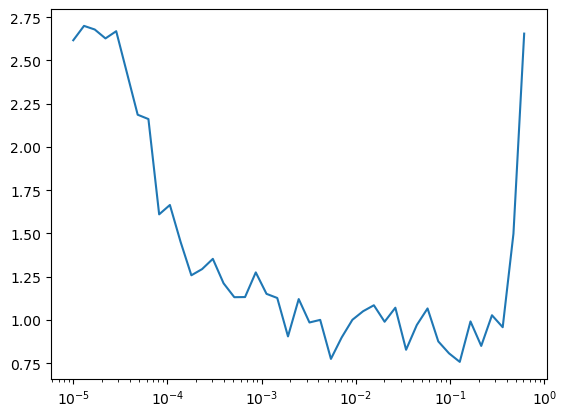

In [10]:
learn.lr_find()

In [11]:
from torchvision import transforms
from torcheval.metrics import MulticlassAccuracy

tfms = nn.Sequential(
    transforms.RandomCrop(size=28, padding=1),
    transforms.RandomHorizontalFlip(),
    # RandomErase(max_n=10, pct=0.2),
)


def im_tfms(b):
    xb, yb = b
    return tfms(xb), yb

tfmcb = BatchTransformCB(im_tfms, valid=False)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch: 0it [00:00, ?it/s]

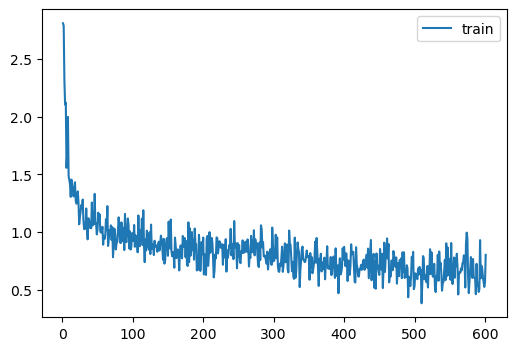

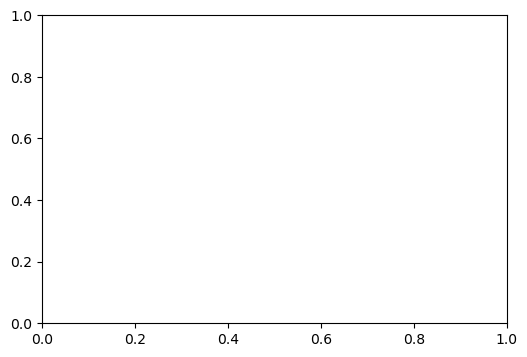

RuntimeError: 0D or 1D target tensor expected, multi-target not supported

In [12]:
learn = get_learner()
learn.fit_one_cycle(5, lr=1e-2, cbs=[MetricsCB(accuracy=MulticlassAccuracy()), PlotMetricsCB(), tfmcb])

So we get 93% accuracy in 5 epochs, lets try adjusting the OneCycle

In [ ]:
from torch.optim import lr_scheduler

max_lr = 1e-2
tmax = 5 * len(dls.train)
pct_start = 0.1
anneal_strategy="cos" # 0.9340 with linear, 0.9339 with cos!
sched = partial(lr_scheduler.OneCycleLR, max_lr=max_lr, total_steps=tmax, pct_start=pct_start, anneal_strategy=anneal_strategy)

schedcb = BatchSchedCB(sched)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

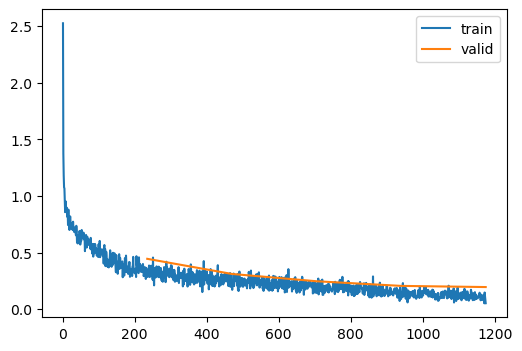

   epoch    train     loss accuracy
       0    train   0.5226   0.8497
       0     eval   0.4447   0.8435


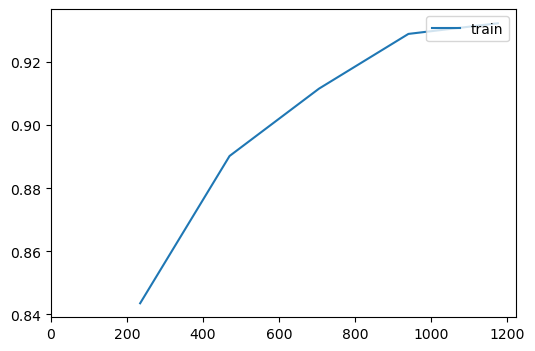

       1    train   0.2893   0.9025
       1     eval   0.3111   0.8903
       2    train   0.2260   0.9222
       2     eval   0.2465   0.9116
       3    train   0.1744   0.9396
       3     eval   0.2055   0.9290
       4    train   0.1259   0.9584
       4     eval   0.1952   0.9324


In [ ]:
learn = get_learner()
learn.fit(5, lr=1e-2, cbs=[MetricsCB(accuracy=MulticlassAccuracy()), PlotMetricsCB(), tfmcb, schedcb])

## Dropout

In [18]:
from functools import partial
from torch import nn
from torch import optim


def get_model():
    act = partial(GeneralReLU, leak=0.1, sub=0.4)
    # act = nn.ReLU
    norm = nn.BatchNorm2d
    drop = 0.4

    layers = [
        ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm),
        nn.Dropout2d(p=0.05),
        ResBlock(16, 32, stride=2, act=act, norm=norm),
        nn.Dropout2d(p=0.05),
        ResBlock(32, 64, stride=2, act=act, norm=norm),
        nn.Dropout2d(p=0.1),
        ResBlock(64, 128, stride=2, act=act, norm=norm),
        nn.Dropout2d(p=0.2),
        ResBlock(128, 256, stride=2, act=act, norm=norm),
        nn.Dropout2d(p=drop),
        ResBlock(256, 512, stride=2, act=act, norm=norm),
        nn.Flatten(),
        nn.Dropout(p=drop),
        nn.Linear(512, 10, bias=False),
        nn.BatchNorm1d(10),
    ]
    return nn.Sequential(*layers)


def get_learner():
    model = get_model()
    init_params_(model, leaky=0.1)
    return Trainer(model, dls, loss_func=cross_entropy, cbs=PlotLossCB(plot_every=100))

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Batch: 0it [00:00, ?it/s]

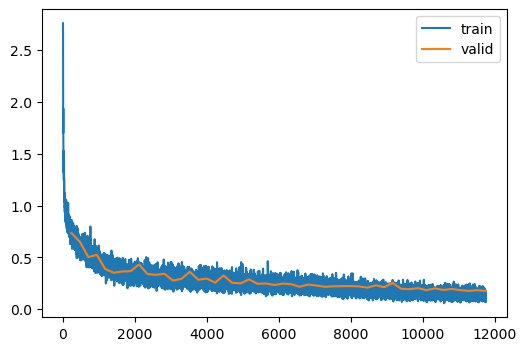

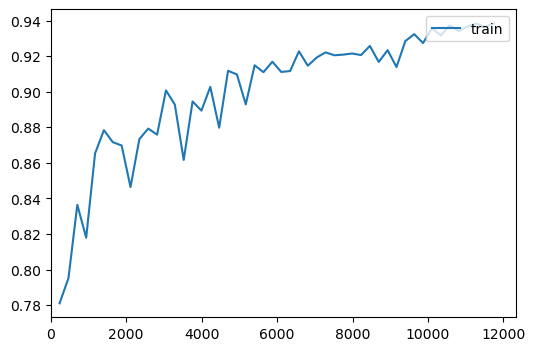

   epoch    train     loss accuracy
       0    train   0.9684   0.7148
       0     eval   0.7338   0.7810
       1    train   0.6725   0.8133
       1     eval   0.6506   0.7951
       2    train   0.5654   0.8350
       2     eval   0.5024   0.8364
       3    train   0.4967   0.8463
       3     eval   0.5239   0.8179
       4    train   0.4429   0.8548
       4     eval   0.3872   0.8652
       5    train   0.3933   0.8662
       5     eval   0.3512   0.8784
       6    train   0.3682   0.8728
       6     eval   0.3632   0.8716
       7    train   0.3482   0.8782
       7     eval   0.3663   0.8698
       8    train   0.3338   0.8828
       8     eval   0.4319   0.8464
       9    train   0.3234   0.8862
       9     eval   0.3383   0.8734
      10    train   0.3106   0.8899
      10     eval   0.3314   0.8792
      11    train   0.3072   0.8903
      11     eval   0.3414   0.8759
      12    train   0.3039   0.8916
      12     eval   0.2759   0.9007
      13    train   0.2932  

In [19]:
learn = get_learner()
learn.fit_one_cycle(50, lr=1e-2, cbs=[MetricsCB(accuracy=MulticlassAccuracy()), PlotMetricsCB(), tfmcb])

In [20]:
learn.save("fashion-mnist-clf-dropout-aug.pkl")

/home/tom/fun/tinyai/tinyai/learner.py:205: UserWarning: /home/tom/.cache/tinyai/models/fashion-mnist-clf-dropout-aug.pkl already exists, overwriting
  warnings.warn(f"{save_file} already exists, overwriting")
